# Rule Translation Reviewer

Use this notebook to step through each guideline clause, inspect its ASP translation, provide a rating (0–3), optionally add comments, and export the evaluation summary to CSV.



In [3]:
from pathlib import Path
import html

import pandas as pd
import yaml
import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.append('..')
from src.review.review_data import build_rule_review_dataset
from src.processing.ASPRuleParser import ASPRuleParser
widgets.HTML("<b>widgets ok</b>")

HTML(value='<b>widgets ok</b>')

## Load file

In [5]:
PROJECT_ROOT = Path.cwd().parent
CONFIG_PATH = PROJECT_ROOT / "src/configs/config.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

# CHANGE THIS to switch between different response files
# Options: "rulegen_response_fired.lp", "in_context_response.txt", "zero_shot_response.txt"
response_file = "zero_shot_response.txt"

# Extract a clean name for the review (e.g., "rulegen" from "rulegen_response_fired.lp")
if "rulegen" in response_file:
    review_name = "rulegen_test"
elif "in_context" in response_file:
    review_name = "in_context_test"
elif "zero_shot" in response_file:
    review_name = "zero_shot_test"
else:
    review_name = response_file.replace('.lp', '').replace('.txt', '')

# Create reviews directory if it doesn't exist
reviews_dir = PROJECT_ROOT / config["experiment"]["output_dir"] / "reviews"
reviews_dir.mkdir(exist_ok=True)

guideline_path = PROJECT_ROOT / config["input_files"]["problem_text"]
lp_file_path = PROJECT_ROOT / config["experiment"]["output_dir"] / config["experiment"]["cancer_type"] / response_file
review_csv_path = reviews_dir / f"rule_review_{review_name}.csv"

dataset = build_rule_review_dataset(str(guideline_path), str(lp_file_path))

# Expand dataset: for each guideline with multiple ASP rules, create separate rows
# so we can review each ASP rule individually
expanded_records = []
for item in dataset:
    asp_rules = item.asp_rules
    if not asp_rules:
        # No translation - still show the guideline
        expanded_records.append({
            "guideline_id": item.guideline_id,
            "guideline_text": item.guideline_text,
            "asp_rule_id": None,
            "asp_rule_text": None,
            "asp_rule_index": 0,
            "total_asp_rules": 0,
        })
    else:
        # Show guideline once, then each ASP rule individually
        for idx, rule in enumerate(asp_rules):
            expanded_records.append({
                "guideline_id": item.guideline_id,
                "guideline_text": item.guideline_text,
                "asp_rule_id": rule["rule_id"],
                "asp_rule_text": rule["rule_text"],
                "asp_rule_index": idx,
                "total_asp_rules": len(asp_rules),
            })

df = pd.DataFrame(expanded_records)
df["rating"] = None
df["comment"] = ""

# Try to load existing review if it exists
if review_csv_path.exists():
    try:
        existing_df = pd.read_csv(review_csv_path)
        # Fill NaN values in existing_df for comparison
        existing_df["asp_rule_id"] = existing_df["asp_rule_id"].fillna("")
        
        # Merge existing ratings and comments by matching guideline_id and asp_rule_id
        loaded_count = 0
        # Normalize existing_df for comparison
        existing_df["asp_rule_id"] = existing_df["asp_rule_id"].astype(str).fillna("")
        existing_df["guideline_id"] = existing_df["guideline_id"].astype(str)
        
        for idx, row in df.iterrows():
            current_asp_rule_id = str(row["asp_rule_id"]) if pd.notna(row["asp_rule_id"]) else ""
            current_guideline_id = str(row["guideline_id"])
            
            match = existing_df[
                (existing_df["guideline_id"] == current_guideline_id) &
                (existing_df["asp_rule_id"] == current_asp_rule_id)
            ]
            if not match.empty:
                match_row = match.iloc[0]
                rating_val = match_row.get("rating")
                comment_val = match_row.get("comment", "")
                
                if pd.notna(rating_val):
                    try:
                        df.at[idx, "rating"] = int(float(rating_val))
                    except (ValueError, TypeError):
                        pass
                if pd.notna(comment_val) and str(comment_val).strip() != "nan":
                    df.at[idx, "comment"] = str(comment_val)
                loaded_count += 1
        if loaded_count > 0:
            display(f"Loaded existing review from {review_csv_path} ({loaded_count} items)")
    except Exception as e:
        display(f"Could not load existing review: {e}")

translations_count = df["asp_rule_id"].notna().sum()
display(f"Reviewing: {review_name}")
display(f"Loaded {len(df)} review items ({len(dataset)} guidelines, {translations_count} ASP rule translations).")



'Reviewing: zero_shot_test'

'Loaded 54 review items (25 guidelines, 54 ASP rule translations).'

## Run assessment program

In [ ]:
rating_labels = {
    0: "0 – No Rule",
    1: "1 – Correct",
    2: "2 – Incorrect",
    3: "3 – Key information missed",
    4: "4 – Information hallucinated",
}

rating_options = [("Select rating", None)] + [
    (label, value) for value, label in rating_labels.items()
]

asp_parser = ASPRuleParser() 

current_index = 0
rule_display = widgets.HTML(layout=widgets.Layout(width="100%"))
rating_dropdown = widgets.Dropdown(options=rating_options, value=None, description="Rating:")
comment_box = widgets.Textarea(
    value="",
    description="Comment:",
    placeholder="Optional notes...",
    layout=widgets.Layout(width="100%", height="100px"),
)
progress_label = widgets.Label()
output_area = widgets.Output()

prev_button = widgets.Button(description="◀ Previous", button_style="info")
next_button = widgets.Button(description="Next ▶", button_style="info")
save_button = widgets.Button(description="Save to CSV", button_style="success")
summary_button = widgets.Button(description="Show Summary", button_style="warning")


def _format_html_text(text: str) -> str:
    escaped = html.escape(text)
    return escaped.replace("\n", "<br>")


def build_rule_html(row: pd.Series) -> str:
    guideline_html = f"<h3>Guideline {row['guideline_id']}</h3><p>{_format_html_text(row['guideline_text'])}</p>"
    # Show the specific ASP rule being reviewed
    asp_rule_id = row.get("asp_rule_id")
    asp_rule_text = row.get("asp_rule_text")
    total_asp_rules = row.get("total_asp_rules", 0)
    asp_rule_index = row.get("asp_rule_index", 0)
    
    if pd.notna(asp_rule_id) and asp_rule_text:
        # Show which rule we're reviewing if there are multiple
        rule_counter = ""
        if total_asp_rules > 1:
            rule_counter = f" (Rule {asp_rule_index + 1} of {total_asp_rules})"
        
        rule_id_escaped = html.escape(str(asp_rule_id))
        rule_text_escaped = _format_html_text(str(asp_rule_text))
        
        # Generate natural language explanation
        try:
            nl_explanation = asp_parser.explain_rule(str(asp_rule_text), str(asp_rule_id))
            nl_explanation_escaped = _format_html_text(nl_explanation)
            nl_section = f"<div style='margin-top:12px; padding:12px; background-color:#e8f4f8; border-left: 4px solid #2196F3;'><strong>Natural Language:</strong><br>{nl_explanation_escaped}</div>"
        except Exception as e:
            nl_section = f"<div style='margin-top:12px; padding:8px; background-color:#ffebee; border-left: 4px solid #f44336;'><em>Error parsing rule: {html.escape(str(e))}</em></div>"
        
        asp_html = f"""
        <h4>ASP Translation{rule_counter}</h4>
        <div style='margin:10px 0;'>
            <code>{rule_id_escaped}</code><br>
            <div style='margin-top:8px; font-family:monospace; padding:8px; background-color:#f5f5f5;'>
                {rule_text_escaped}
            </div>
            {nl_section}
        </div>
        """
    else:
        asp_html = "<p><strong>No translation found.</strong></p>"

    return guideline_html + asp_html


def persist_current_state():
    rating_val = rating_dropdown.value
    comment_val = comment_box.value.strip() if comment_box.value else ""
    df.at[current_index, "rating"] = rating_val
    df.at[current_index, "comment"] = comment_val


def update_view():
    row = df.iloc[current_index]
    rule_display.value = build_rule_html(row)
    rating_value = row["rating"]
    if pd.isna(rating_value):
        rating_value = None
    rating_dropdown.value = rating_value
    comment_box.value = str(row["comment"]) if pd.notna(row["comment"]) else ""
    progress_label.value = f"Item {current_index + 1} of {len(df)}"
    prev_button.disabled = current_index == 0
    next_button.disabled = current_index == len(df) - 1


def on_prev(_):
    global current_index
    persist_current_state()
    if current_index > 0:
        current_index -= 1
    update_view()


def on_next(_):
    global current_index
    persist_current_state()
    if current_index < len(df) - 1:
        current_index += 1
    update_view()


def prepare_export_dataframe() -> pd.DataFrame:
    export_df = df.copy()
    # Convert None to empty string for CSV export
    export_df["asp_rule_id"] = export_df["asp_rule_id"].fillna("")
    export_df["asp_rule_text"] = export_df["asp_rule_text"].fillna("")
    export_df["comment"] = export_df["comment"].fillna("")
    return export_df


def on_save(_):
    persist_current_state()
    export_df = prepare_export_dataframe()
    export_df.to_csv(review_csv_path, index=False)
    with output_area:
        output_area.clear_output()
        print(f"Saved {len(export_df)} rows to {review_csv_path}")


def on_summary(_):
    persist_current_state()
    rated = df.dropna(subset=["rating"])
    with output_area:
        output_area.clear_output()
        if rated.empty:
            print("No ratings captured yet.")
            return

        summary = (
            rated.groupby("rating").size().reindex(sorted(rating_labels.keys()), fill_value=0)
        )
        total = summary.sum()
        summary_df = pd.DataFrame({
            "rating": summary.index,
            "description": [rating_labels[idx] for idx in summary.index],
            "count": summary.values,
            "percentage": (summary.values / total * 100).round(2),
        })
        display(summary_df)

        # Filter comments - handle NaN and empty strings
        def has_comment(val):
            if pd.isna(val):
                return False
            s = str(val).strip()
            return s != "" and s.lower() != "nan"
        
        comments_df = rated[rated["comment"].apply(has_comment)]
        if not comments_df.empty:
            display(comments_df[["guideline_id", "asp_rule_id", "comment"]])


prev_button.on_click(on_prev)
next_button.on_click(on_next)
save_button.on_click(on_save)
summary_button.on_click(on_summary)

controls = widgets.VBox([
    rule_display,
    widgets.HBox([rating_dropdown, progress_label]),
    comment_box,
    widgets.HBox([prev_button, next_button, save_button, summary_button]),
    output_area,
])

display(controls)
update_view()



## Plot graphs

Saved comparison chart: /Users/ashvingupta/Documents/PhD/NICE2ASP2/src/output_files/CLAUDE/reviews/rating_comparison.png


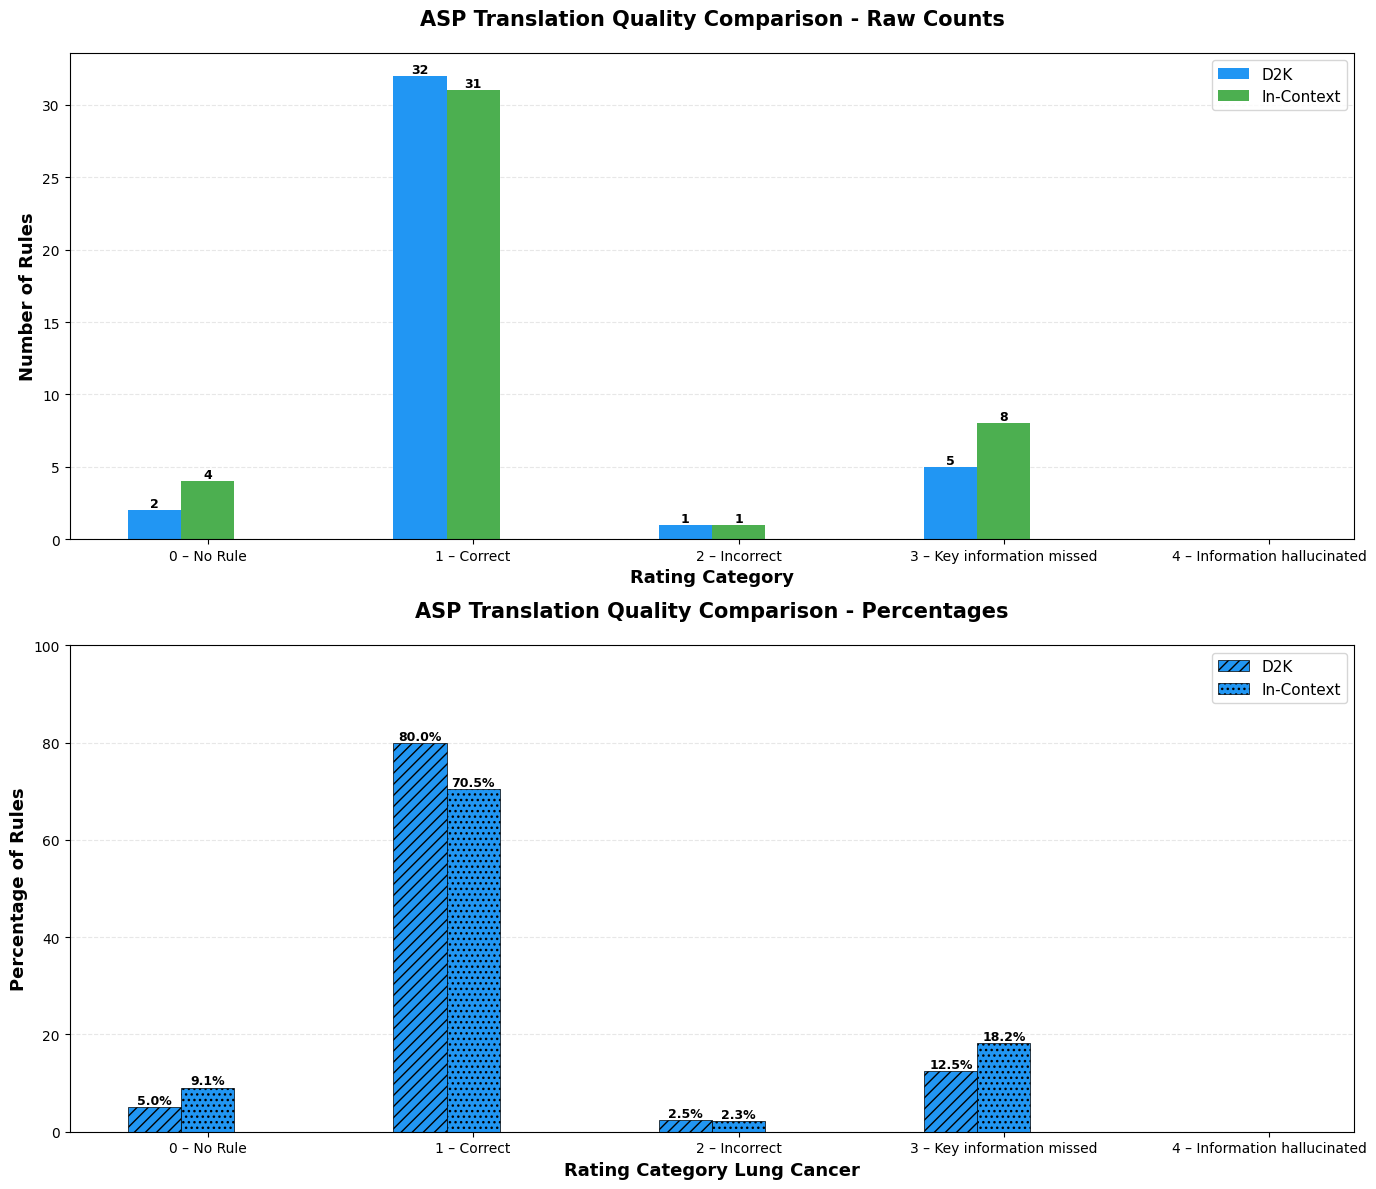


=== Comparison Summary ===
Approach        Total    Correct  Accuracy   No Rule  Incorrect Key Information Missed Information Hallucinated
-------------------------------------------------------------------------------------
D2K             40       32       80.0     % 2        1        5          0       
In-Context      44       31       70.5     % 4        1        8          0       


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Load the review CSV
PROJECT_ROOT = Path.cwd().parent
CONFIG_PATH = PROJECT_ROOT / "src/configs/config.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

reviews_dir = PROJECT_ROOT / config["experiment"]["output_dir"] / "reviews"


# Define rating labels
rating_labels = {
    0: "0 – No Rule",
    1: "1 – Correct",
    2: "2 – Incorrect",
    3: "3 – Key information missed",
    4: "4 – Information hallucinated",
}

review_files = {
    'D2K': 'rule_review_rulegen.csv',
    'In-Context': 'rule_review_in_context.csv',
    'Zero-Shot': 'rule_review_zero_shot.csv',
}

# Collect data for all approaches
all_data = {}
for approach_name, filename in review_files.items():
    review_path = reviews_dir / filename
    if review_path.exists():
        df = pd.read_csv(review_path)
        rated_df = df[df['rating'].notna() & (df['rating'] != '')]
        if len(rated_df) > 0:
            rating_counts = rated_df['rating'].value_counts()
            all_data[approach_name] = {
                'counts': rating_counts,
                'total': len(rated_df)
            }

if not all_data:
    print("No review data found!")
else:
    # Create comparison chart with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    x = np.arange(5)  # 5 rating categories (0, 1, 2, 3, 4)
    width = 0.2
    
    colors = {'D2K': '#2196F3', 'In-Context': '#4CAF50', 'Zero-Shot': '#FF9800'}
    patterns = {'D2K': '///', 'In-Context': '...', 'Zero-Shot': 'xxx'}
    
    # First subplot - Raw counts
    multiplier = 0
    for approach_name, data in all_data.items():
        counts = [data['counts'].get(i, 0) for i in range(5)]
        offset = width * multiplier
        bars = ax1.bar(x + offset, counts, width, label=approach_name, 
                      color=colors.get(approach_name, '#999'))
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        multiplier += 1
    
    ax1.set_xlabel('Rating Category', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Rules', fontsize=13, fontweight='bold')
    ax1.set_title('ASP Translation Quality Comparison - Raw Counts', 
                  fontsize=15, fontweight='bold', pad=20)
    ax1.set_xticks(x + width)
    ax1.set_xticklabels([rating_labels[i] for i in range(5)])
    ax1.legend(loc='upper right', fontsize=11)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_axisbelow(True)
    
    # Second subplot - Percentages with patterns
    multiplier = 0
    for approach_name, data in all_data.items():
        counts = [data['counts'].get(i, 0) for i in range(5)]
        percentages = [(count / data['total'] * 100) if data['total'] > 0 else 0 for count in counts]
        offset = width * multiplier
        bars = ax2.bar(x + offset, percentages, width, label=approach_name, 
                      color='#2196F3', hatch=patterns.get(approach_name, ''), 
                      edgecolor='black', linewidth=0.5)
        
        # Add percentage labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        multiplier += 1
    
    ax2.set_xlabel('Rating Category Lung Cancer', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Percentage of Rules', fontsize=13, fontweight='bold')
    ax2.set_title('ASP Translation Quality Comparison - Percentages', 
                  fontsize=15, fontweight='bold', pad=20)
    ax2.set_xticks(x + width)
    ax2.set_xticklabels([rating_labels[i] for i in range(5)])
    ax2.legend(loc='upper right', fontsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)
    ax2.set_ylim(0, 100)
    
    plt.tight_layout()
    
    # Save
    output_path = reviews_dir / "rating_comparison.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved comparison chart: {output_path}")
    
    plt.show()
    
    # Print comparison table
    print("\n=== Comparison Summary ===")
    print(f"{'Approach':<15} {'Total':<8} {'Correct':<8} {'Accuracy':<10} {'No Rule':<8} {'Incorrect':<8} {'Key Information Missed':<8} {'Information Hallucinated':<8}")
    print("-" * 85)
    for approach_name, data in all_data.items():
        counts = data['counts']
        total = data['total']
        right = counts.get(1, 0)
        accuracy = (right / total * 100) if total > 0 else 0
        no_rule = counts.get(0, 0)
        incorrect = counts.get(2, 0)
        missed = counts.get(3, 0)
        halluc = counts.get(4, 0)
        print(f"{approach_name:<15} {total:<8} {right:<8} {accuracy:<9.1f}% "
              f"{no_rule:<8} {incorrect:<8} {missed:<10} {halluc:<8}")

## Assess K2P

In [20]:
import re
import pandas as pd
from pathlib import Path

# Adjust this if your notebook is not at the repo root
BASE_DIR = Path("/Users/ashvingupta/Documents/PhD/NICE2ASP2/")  # repo root
GT_PATH = BASE_DIR / "src" / "output_files" / "CLAUDE" / "pancreatic cancer" / "K2P_ground_truth.csv"
CLINGO_PATH = BASE_DIR / "src" / "output_files" / "CLAUDE" / "pancreatic cancer" / "clingo_output.txt"

# --- 1. Load and parse ground truth ---

gt_df = pd.read_csv(GT_PATH)

def parse_rule_list(s):
    """
    Example input: "[1.1.4; 1.1.18]"
    Output: set of strings: {"1.1.4", "1.1.18"}
    """
    if pd.isna(s):
        return set()
    s = s.strip()
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1]
    # split on ';' and strip whitespace
    rules = [r.strip() for r in s.split(";") if r.strip()]
    return set(rules)

gt_rules_by_patient = {
    int(row["Patient"]): parse_rule_list(row["Rules to fire"])
    for _, row in gt_df.iterrows()
}

# --- 2. Load and parse clingo output ---

clingo_rules_by_patient = {}
current_patient = None

with open(CLINGO_PATH, "r") as f:
    for line in f:
        line = line.strip()

        # Detect patient header: "=== Patient X ==="
        m = re.match(r"=== Patient\s+(\d+)\s+===", line)
        if m:
            current_patient = int(m.group(1))
            clingo_rules_by_patient.setdefault(current_patient, set())
            continue

        if current_patient is None:
            continue

        # Extract all fired("...") occurrences on this line
        fired_rules = re.findall(r'fired\("([^"]+)"\)', line)
        if fired_rules:
            clingo_rules_by_patient[current_patient].update(fired_rules)

# --- 3. Compute TP, FP, FN across all patients ---

all_patients = sorted(set(gt_rules_by_patient.keys()) | set(clingo_rules_by_patient.keys()))

total_tp = total_fp = total_fn = 0

per_patient_metrics = []  # optional: to inspect per-patient performance

for pid in all_patients:
    gt = gt_rules_by_patient.get(pid, set())
    pred = clingo_rules_by_patient.get(pid, set())

    tp = len(gt & pred)
    fp = len(pred - gt)
    fn = len(gt - pred)

    total_tp += tp
    total_fp += fp
    total_fn += fn

    # per-patient precision/recall/F1 (optional)
    prec_p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec_p = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_p = 2 * prec_p * rec_p / (prec_p + rec_p) if (prec_p + rec_p) > 0 else 0.0

    per_patient_metrics.append({
        "Patient": pid,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": prec_p,
        "Recall": rec_p,
        "F1": f1_p,
        "GT_rules": sorted(gt),
        "Pred_rules": sorted(pred),
    })

per_patient_df = pd.DataFrame(per_patient_metrics).set_index("Patient")

# --- 4. Global (micro-averaged) precision, recall, F1 ---

precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print("=== Global metrics (micro-averaged over all patient–rule pairs) ===")
print(f"TP: {total_tp}, FP: {total_fp}, FN: {total_fn}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}")

# To inspect per-patient metrics:
per_patient_df

=== Global metrics (micro-averaged over all patient–rule pairs) ===
TP: 59, FP: 7, FN: 18
Precision: 0.894
Recall:    0.766
F1 score:  0.825


,TP,FP,FN,Precision,Recall,F1,GT_rules,Pred_rules
Patient,,,,,,,,
1,2,0,0,1.000000,1.000000,1.000000,"[1.1.18, 1.1.4]","[1.1.18, 1.1.4]"
2,5,1,2,0.833333,0.714286,0.769231,"[1.1.18, 1.1.4, 1.1.5, 1.13.2, 1.13.2_B, 1.2.5...","[1.1.18, 1.1.4, 1.13.2, 1.13.2_B, 1.2.5, 1.2.5_B]"
3,5,2,0,0.714286,1.000000,0.833333,"[1.1.18, 1.1.7, 1.13.2, 1.13.2_B, 1.2.5]","[1.1.18, 1.1.4, 1.1.7, 1.13.2, 1.13.2_B, 1.2.5..."
4,2,0,0,1.000000,1.000000,1.000000,"[1.1.18, 1.2.4]","[1.1.18, 1.2.4]"
5,2,0,2,1.000000,0.500000,0.666667,"[1.1.18, 1.1.4, 1.1.5, 1.1.6]","[1.1.18, 1.1.4]"
6,2,0,1,1.000000,0.666667,0.800000,"[1.1.18, 1.1.4, 1.1.5]","[1.1.18, 1.1.4]"
7,4,0,3,1.000000,0.571429,0.727273,"[1.1.18, 1.1.4, 1.1.5, 1.1.6, 1.13.2, 1.13.2_B...","[1.1.18, 1.13.2, 1.13.2_B, 1.2.4]"
8,2,0,0,1.000000,1.000000,1.000000,"[1.1.18, 1.1.4]","[1.1.18, 1.1.4]"
9,2,0,0,1.000000,1.000000,1.000000,"[1.1.18, 1.1.4]","[1.1.18, 1.1.4]"
